In [1]:
%pylab inline

import sys,os
import time, datetime, dateutil 
import re, glob
import cPickle as pickle

import numpy as np
import pandas as pd

import scipy
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from skimage import filters

import matplotlib.patches as patches

from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import stats

import tensorflow as tf
import lex4
from params import P, H, W, T, init_params

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_rows = 202
pd.options.display.max_columns = 99

pd.options.display.float_format = '{:,.4f}'.format

In [4]:
basedir = "."
run = "."
rundir = "%s/%s/"%(basedir, run)
submit_node='darmok.cs.utexas.edu'  #azog
print "RUNDIR", rundir

RUNDIR ././


In [5]:
# difference of gaussians
def make_dog(x,y,sigma1=None,sigma2=None):

    dog = np.zeros([x,y,x,y], dtype=np.float32)
    
    for xi in range(x):
        for yi in range(y):
            one = np.zeros((x,y), dtype=np.float32)
            one[xi,yi] = 1.0
            
            if sigma1 is not None:
                plus = filters.gaussian(one,sigma1, mode='reflect')
            else:
                plus = one
                
            if sigma2 is not None:
                minus = filters.gaussian(one,sigma2, mode='reflect')
            else:
                minus = np.ones((x,y), dtype=np.float32)/(x*y)
                
            dog[xi,yi,:,:] = plus - minus   
    return dog/np.linalg.norm(dog, axis=(0,1))#.reshape([12,12])

dog = make_dog(12,12,1.0,7.0)

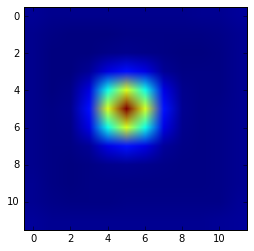

In [6]:
imshow(dog[5,5])

In [7]:
FTYPE = tf.float32
ITYPE = tf.int32  

zeroi_ = tf.constant(0, ITYPE)
onei_ = tf.constant(1, ITYPE)
zerof_ = tf.constant(0., FTYPE)
onef_ = tf.constant(1., FTYPE)
tinyf_ = tf.constant(1e-8, dtype=FTYPE)
log2f_ = tf.constant(np.log(2), dtype=FTYPE)            
    
class StroopSom:
    
    def __init__(self, data, x=None, y=None, W=None,
                sigma1=None, sigma2=None, 
                 name="som", sess=None):

        sess = sess or tf.get_default_session()
        
        self.name = name        
        self.x, self.y, self.dim = W.shape if W is not None else (x,y,data.shape[1])
        
        with tf.name_scope(self.name):
                    
            ### VARIABLES                       
            
            self.W_ = tf.Variable(W if W is not None else 0.001*np.random.random_sample([self.x,self.y,self.dim]), dtype=FTYPE, name="W")   
            
            self.lat_W_ = tf.constant(make_dog(self.x, self.y, sigma1, sigma2), dtype=FTYPE, name="lat_W")
            
            ### INPUT            
            self.i_ = tf.placeholder(shape=([]), dtype=ITYPE, name="i")
            self.data = data
            self.data_ = tf.constant(data.values, dtype=FTYPE)
            self.input_ = tf.gather(self.data_, self.i_)
                        
            self.xi_ = tf.constant(self.x, ITYPE)
            self.yi_ = tf.constant(self.y, ITYPE)
            self.xf_ = tf.constant(self.x, FTYPE)
            self.yf_ = tf.constant(self.y, FTYPE)                                               
        
        
            ### PRESENT          
            self.raw_diff_ = tf.subtract(tf.reshape(self.input_,
                                                    [1,1,self.dim],
                                                    name="reshape_input"),
                                         self.W_)


            self.dist2_ = tf.reduce_sum(tf.square(self.raw_diff_),axis=2)
            
            self.winner_ = tf.argmin(tf.reshape(self.dist2_,
                                                [self.x*self.y]),
                                     axis=0,
                                     name="winner",
                                     output_type=ITYPE) 


            self.wx_ = tf.floordiv(self.winner_, self.yi_, name="wx")         
            self.wy_ = tf.floormod(self.winner_, self.yi_, name="wy")
           
            
            ### PRESENT BATCH            
            self.batch_input_ = tf.placeholder(dtype=FTYPE, shape=[None, self.dim], name="batch_input")

            self.batch_raw_diff_ = tf.subtract(tf.reshape(self.batch_input_,
                                                          [-1,1,1,self.dim]),
                                               tf.reshape(self.W_,
                                                         [1, self.x,self.y,self.dim]))


            self.batch_dist2_ = tf.reduce_sum(tf.square(self.batch_raw_diff_),axis=3)                 


            self.labels_ = tf.argmin(self.batch_dist2_,
                                     axis=0,
                                     name="labels",
                                     output_type=ITYPE)
           
            #ACTIVATION            
            self.act = numpy.zeros([self.x, self.y], dtype=np.float32)
            
            self.act_ = tf.placeholder(shape=[self.x, self.y], dtype=FTYPE)
        
            self.input_strength_ = tf.placeholder_with_default(0.0, shape=[], name="inp_strength")
            #self.input_act_ = tf.clip_by_norm(onef_ / (self.dist2_ + onef_) - 0.25, 1.0)    
            self.input_act_ = tf.clip_by_norm(onef_ / (self.dist2_ + onef_) - onef_/(self.dim+onef_), onef_)    
            
            self.lat_strength_ = tf.placeholder_with_default(1.0, shape=[], name="lat_strength")
            self.lat_act_ = tf.reduce_sum(tf.multiply(tf.reshape(self.act_, 
                                                                 [1,1,self.x,self.y]),
                                                      self.lat_W_),
                                                      axis=[2,3])

            
            self.next_act_ = tf.clip_by_norm(tf.clip_by_value(self.input_strength_*self.input_act_ + self.lat_strength_*self.lat_act_, 
                                                              clip_value_min=0.0,
                                                              clip_value_max=1.0),
                                             clip_norm=1.0,
                                             name="next_act")
            
            sess.run(tf.variables_initializer([self.W_])) #, self.act_]))

            self.labels = sess.run(self.labels_, feed_dict={self.batch_input_: self.data.values})

            x,y = np.meshgrid(arange(self.x), arange(self.y))
            cxy = np.array([self.labels.reshape([-1]),y.reshape([-1]),x.reshape([-1])]).T
            cxy = cxy[cxy[:, 0].argsort()]

            self.classes_ = tf.constant(cxy[:,0], dtype=ITYPE)
            self.class_indices_ = tf.constant(cxy[:,1:], dtype=ITYPE)

            segsums_ = tf.segment_sum(tf.gather_nd(self.act_, self.class_indices_), self.classes_)
            self.class_hist_ = segsums_/tf.norm(segsums_, ord=1)
            self.output_class_ = tf.argmax(self.class_hist_)
            
            max_bits = np.log(len(self.data))/np.log(2.0)
            self.output_bits_ = max_bits+tf.reduce_sum(self.class_hist_*tf.log(self.class_hist_+tinyf_)/log2f_)


                                                                   

In [8]:
SEM2ENG = 0
ENG2SEM = 1
SEM2SPA = 2 
SPA2SEM = 3 
ENG2SPA = 4
SPA2ENG = 5

class StroopLex:
    
    input_decay = 0.95
    
    def __init__(self, sem, eng, spa, assoc, sem_data, eng_data, spa_data, lang='eng', sess=None):
               
        sess = sess or tf.get_default_session()

        self.lang = lang
        
        with sess.as_default():
            self.sem =  StroopSom(W=sem, data=sem_data, sess=sess)
            self.eng =  StroopSom(W=eng, data=eng_data, sess=sess)
            self.spa =  StroopSom(W=spa, data=spa_data, sess=sess)

        self.input_labels = sem_data.index
        
        ### ASSOCIATIVE CONNECTIONS
        
        def make_prop_op(i, src, name):
            with tf.name_scope(name):
                weights_ = tf.constant(assoc[i], dtype=FTYPE, name="weights")
                prop_ = tf.reduce_sum(tf.multiply(tf.reshape(src.act_,
                                                             [src.x,src.y,1,1]),
                                                  weights_),
                                      axis=[0,1],
                                      name="prop")
                strength_ = tf.placeholder_with_default(0.0, shape=[], name="strength")

                return weights_, prop_, strength_

        if lang in ['both', 'eng']:            
            self.sem2eng_, self.sem2eng_prop_, self.sem2eng_strength_ = make_prop_op(SEM2ENG, self.sem, "sem2eng")
            self.eng2sem_, self.eng2sem_prop_, self.eng2sem_strength_ = make_prop_op(ENG2SEM, self.eng, "eng2sem")
        if lang in ['both', 'spa']:            
            self.sem2spa_, self.sem2spa_prop_, self.sem2spa_strength_ = make_prop_op(SEM2SPA, self.sem, "sem2spa")
            self.spa2sem_, self.spa2sem_prop_, self.spa2sem_strength_ = make_prop_op(SPA2SEM, self.spa, "spa2sem")
        if lang == 'both':               
            self.eng2spa_, self.eng2spa_prop_, self.eng2spa_strength_ = make_prop_op(ENG2SPA, self.eng, "eng2spa")
            self.spa2eng_, self.spa2eng_prop_, self.spa2eng_strength_ = make_prop_op(SPA2ENG, self.spa, "spa2eng")
        
        if lang == 'both': 
            self.next_sem_ = tf.clip_by_norm(tf.nn.relu(tf.add_n([sem.input_strength_*self.sem.input_act_,
                                                                  self.sem.lat_strength_*self.sem.lat_act_,
                                                                  self.eng2sem_strength_*self.eng2sem_prop_,
                                                                  self.spa2sem_strength_*self.spa2sem_prop_])),
                                             clip_norm=1.0,
                                             name="next_sem")  

            self.next_eng_ = tf.clip_by_norm(tf.nn.relu(tf.add_n([self.eng.input_strength_*self.eng.input_act_,
                                                                  self.eng.lat_strength_*self.eng.lat_act_,
                                                                  self.sem2eng_strength_*self.sem2eng_prop_,
                                                                  self.spa2eng_strength_*self.spa2eng_prop_])),
                                             clip_norm=1.0,
                                             name="next_eng")

            self.next_spa_ = tf.clip_by_norm(tf.nn.relu(tf.add_n([self.spa.input_strength_*self.spa.input_act_,
                                                                  self.spa.lat_strength_*self.spa.lat_act_,
                                                                  self.sem2spa_strength_*self.sem2spa_prop_,
                                                                  self.eng2spa_strength_*self.eng2spa_prop_])),
                                             clip_norm=1.0,
                                             name="next_spa")  
        elif lang == 'eng':
            self.next_sem_ = tf.clip_by_norm(tf.nn.relu(tf.add_n([self.sem.input_strength_*self.sem.input_act_,
                                                                  self.sem.lat_strength_*self.sem.lat_act_,
                                                                  self.eng2sem_strength_*self.eng2sem_prop_])),
                                             clip_norm=1.0,
                                             name="next_sem")  

            self.next_eng_ = tf.clip_by_norm(tf.nn.relu(tf.add_n([self.eng.input_strength_*self.eng.input_act_,
                                                                  self.eng.lat_strength_*self.eng.lat_act_,
                                                                  self.sem2eng_strength_*self.sem2eng_prop_])),
                                             clip_norm=1.0,
                                             name="next_eng")              
        elif lang == 'spa':
            self.next_sem_ = tf.clip_by_norm(tf.nn.relu(tf.add_n([self.sem.input_strength_*self.sem.input_act_,
                                                                  self.sem.lat_strength_*self.sem.lat_act_,
                                                                  self.spa2sem_strength_*self.spa2sem_prop_])),
                                             clip_norm=1.0,
                                             name="next_sem")  

            self.next_spa_ = tf.clip_by_norm(tf.nn.relu(tf.add_n([self.spa.input_strength_*self.spa.input_act_,
                                                                  self.spa.lat_strength_*self.spa.lat_act_,
                                                                  self.sem2spa_strength_*self.sem2spa_prop_])),
                                             clip_norm=1.0,
                                             name="next_spa")              

    @classmethod
    def from_file(cls, file_name, sem_data, eng_data, spa_data, lang='eng', sess=None):
        
        npz = np.load(file_name)
        
        return cls(sem=npz["sem"], eng=npz["eng"], spa=npz["spa"], assoc=npz["assoc"],
                   sem_data=sem_data, eng_data=eng_data, spa_data=spa_data,
                   lang=lang, sess=sess)
    

    def save_as(self, file_name, sess=None):
        
        sess = sess or tf.get_default_session()
        
        sem,eng,spa = sess.run([self.sem.W_,self.eng.W_,self.spa.W_])
        assoc = np.stack(sess.run([self.sem2eng_,self.eng2sem_,self.sem2spa_,self.spa2sem_,self.eng2spa_,self.spa2eng_]))
        np.savez_compressed(file_name, sem=sem, eng=eng, spa=spa, assoc=assoc)
        
        
        
    def test_routing_params(self, context, routing_parameters, sem_i, eng_i=None, spa_i=None, max_steps=150, v=True, vv=False, sess=None):
        
        sess = sess or tf.get_default_session()           
        
        if self.lang != 'eng':
            print "only mono English right now"
            return None
        
        naming,comp,trans,read,perc,eng,spa,stroop_cong, stroop_incong, stroop_neutral=context.tolist()
        
        task = context[['naming','comp','trans','read','perc']].idxmax()           
            
        if task in ['naming', 'read', 'trans']:
            output_map = self.spa if task=='trans' else self.eng
            target_class = sem_i if task=='naming' else eng_i
        elif task in ['comp', 'perc']:
            output_map = self.sem
            target_class = eng_i if task=='comp' else sem_i
        else:
            raise "bad task: "+task
        
        if vv:
            print "Testing %s, lang = %s, input = %s (%r)"%(task, self.lang, self.get_color_name(sem_i), "None" if spa_i is None else self.get_color_name(spa_i))
               
        sem_input_strength = routing_parameters['sem_input_strength']
        eng_input_strength = routing_parameters['eng_input_strength']
        sem2eng_strength = routing_parameters['sem2eng_strength']
        eng2sem_strength = routing_parameters['eng2sem_strength']
        thresh_bits = routing_parameters['thresh']
        
        
        self.sem.act[:,:] = 0.0
        self.eng.act[:,:] = 0.0
        
        output_bits = 0.0
        t = 0
        
        while t <= max_steps:

            feed={self.sem.input_strength_: sem_input_strength,
                  self.eng.input_strength_: eng_input_strength,
                  self.sem2eng_strength_: sem2eng_strength,
                  self.eng2sem_strength_: eng2sem_strength,
                  self.sem.act_: self.sem.act,
                  self.eng.act_: self.eng.act,                                                                                                                          
                 }
            
            if sem_i is not None:
                feed[self.sem.i_] = sem_i
            else:
                feed[self.sem.input_act_] = np.zeros((self.sem.x, self.sem.y), dtype=np.float32)
            
            if eng_i is not None:
                feed[self.eng.i_] = eng_i
            else:
                feed[self.eng.input_act_] = np.zeros((self.eng.x, self.eng.y), dtype=np.float32)

                                
            self.sem.act[:,:], self.eng.act[:,:] = sess.run([self.next_sem_, self.next_eng_], feed_dict=feed)

            output_class, output_bits = sess.run([output_map.output_class_, output_map.output_bits_], feed_dict={output_map.act_: output_map.act})           
            
            sem_input_strength = sem_input_strength*self.input_decay
            eng_input_strength = eng_input_strength*self.input_decay

            if v or vv:
                sys.stdout.write("."); sys.stdout.flush()   

            if output_bits >= thresh_bits:
                if vv:
                    print "t =",t,"done! %.2f bits"%output_bits
                    print "output_class", output_class, "output = %s (%s)"%(self.get_color_name(output_class), "CORRECT!" if output_class==sem_i else "WRONG!")
            
                return output_class==target_class, True, t
            
            t += 1
            
        if vv:
            print "No answer after", max_steps, "steps..."
        
        
        return output_class==target_class, False, max_steps
    
    
    def get_color_index(self, col):        
        return argmax(self.input_labels==col)
    
    def get_color_name(self, i):
        if i is None:
            return 'None'
        else:
            return self.input_labels[i]
    
    def label_pics(self, map):
        return np.array([[self.sem.data.iloc[map.labels[x,y]][['R','G',"B"]].values for y in range(map.y)] for x in range(map.x)])


In [9]:
!nvidia-smi

Tue Mar  8 14:20:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:04:00.0 Off |                  N/A |
| 27%   26C    P8     5W / 180W |      4MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    On   | 00000000:82:00.0 Off |                  N/A |
| 27%   

In [10]:
config = tf.ConfigProto()         
config.gpu_options.allow_growth=False
config.gpu_options.visible_device_list = '0'
         
sess = tf.Session(config=config)

lex = None
current_net = None

In [11]:
pca = False
pi=0

In [12]:
if pca:
    word_file = "colors_pca_2022-02-02.pkl"
else:
    word_file = "colors_2022-02-01.pkl"

param_file = "stroop_params_2021-06-05.pkl"
qpu_file = "humans_11-23-2018.pkl"

In [13]:
opt = init_params([])

W.load(rundir + word_file)
P.load(rundir + param_file)
H.load(rundir + qpu_file)

humans = H.frame

In [14]:
def plot_exposure(hid = "BUBA04"):
    title("%s exposure"%hid)
    age = humans.loc[hid,"age"].astype(int)+1
    exp = humans.loc[hid, ["ENG_EXP%d"%year for year in range(age+2)]]
    ylim(0,1.05)
    xlim(0,age+1)
    plot(range(age+2),exp.values)
    if humans.loc[hid, 'patient']:
        axvline(humans.loc[hid,'age_at_stroke'], color="k", alpha=0.6)
    xlabel("age")
    ylabel("English %")

hid = BUNC172
pi =  0


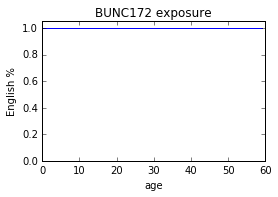

In [15]:
### set patient and parameter set

hid = 'BUNC172'
pi =  0

P.set_pi(pi)
H.set_hid(hid)

print "hid =", H.hid
print "pi = ", P.pi

figsize(4,2.5)
plot_exposure(hid)

In [16]:
#### check out pre-trained nets
!du -h $rundir/stroop_net_*.npz

520K	././/stroop_net_BUNC172_2022-02-06.npz


In [17]:
#### load one of them
net_file = "stroop_net_"+H.hid+"_"+("pca_" if pca else "")+"2022-02-06.npz"
print "loading net from", rundir+net_file
lex = StroopLex.from_file(rundir+net_file, W.sem_data, W.eng_data, W.spa_data, lang='eng', sess=sess)

loading net from ././stroop_net_BUNC172_2022-02-06.npz


In [ ]:
### OR train a new one
    
print "pca = ", pca
print "pi = ", P.pi
print "hid =", H.hid

with tf.device("/gpu:0"), sess.as_default():
    lex = lex4.Lex(W.sem_data, W.eng_data, W.spa_data, x=P.map_size, y=P.map_size, naming_only=False, act_fun=P.act_fun)
    lex.init_model(P, H, sess)

    end_age = H.age

    print "training up to age", end_age

    while(lex.age < end_age):
        step = min(end_age-lex.age, 1.0)
        lex.noise_assoc(P, fraction=step)

        lex.train(lex.age+step, P, H, W, sess)
        lex.norm_assoc(P, sess)
    
### ...and maybe save it for later   

#fname = time.strftime(rundir + "stroop_net_"+H.hid+"_"+("pca_" if pca else "")+"%Y-%m-%d.npz")
#print "saving as", fname
#lex.save_npz(fname, P, T, sess=sess) 

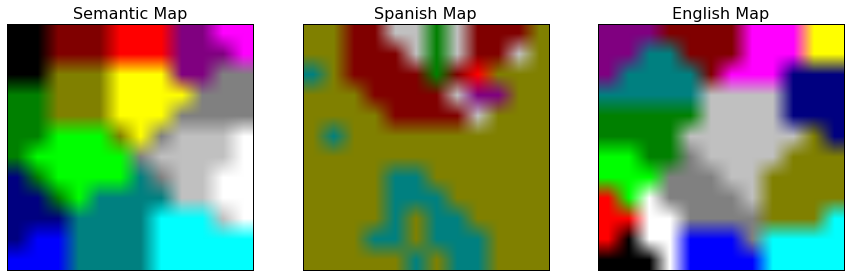

In [18]:
### plot maps

figsize(15,5)

subplot(131)
title("Semantic Map", fontsize=16)
xticks([]); yticks([])
imshow(lex.label_pics(lex.sem))

subplot(132)
title("Spanish Map", fontsize=16)
xticks([]); yticks([])
imshow(lex.label_pics(lex.spa))

subplot(133)
title("English Map", fontsize=16)
xticks([]); yticks([])
imshow(lex.label_pics(lex.eng))

In [19]:
def make_context(naming=False, comp=False, trans=False, read=False, perc=False, eng=False, spa=False, stroop_cong=False, stroop_incong=False, stroop_neutral=False):
    return pd.Series(index=['naming','comp','trans','read','perc','eng','spa','stroop_cong', 'stroop_incong', 'stroop_neutral'], 
                     data=[  naming,  comp,  trans,  read,  perc,  eng,  spa,  stroop_cong, stroop_incong, stroop_neutral])

def make_routing_params(sem_input_strength, eng_input_strength,sem2eng_strength,eng2sem_strength, thresh):
    return pd.Series(index=['sem_input_strength','eng_input_strength', 'sem2eng_strength', 'eng2sem_strength', 'thresh'],
                     data=[sem_input_strength, eng_input_strength, sem2eng_strength, eng2sem_strength, thresh])

In [20]:
### like StroopLex.test_routing_params(...), but returns activations and histograms, and does ONLY English naming

def run_name_color_no_bg(model, context, routing_params, sem_col = "Red", eng_col = "Red", max_steps=150, sess=None):
    
    sess = sess or tf.get_default_session()
    with sess.as_default():
        
        #if routing_params is None:
        #    routing_params = bg.get_routing_params(context, sess=sess)
                
        model.sem.act[:,:] = 0.0 
        model.eng.act[:,:] = 0.0       
        
        sem_act, eng_act, sem_hist, eng_hist, sem_bits, eng_bits = [],[],[],[],[],[]
       
        output_bits = 0.0
        t, final_t = 0, None 

        thresh_bits = routing_params['thresh']
        
        
        while t<=max_steps:
            
            feed={model.sem.input_strength_: routing_params['sem_input_strength'],
                  model.eng.input_strength_: routing_params['eng_input_strength'],
                  model.sem2eng_strength_: routing_params['sem2eng_strength'],
                  model.eng2sem_strength_: routing_params['eng2sem_strength'],
                  model.sem.act_: model.sem.act,
                  model.eng.act_: model.eng.act}                                                                                                                  

            if sem_col is not None:
                feed[model.sem.i_] = model.get_color_index(sem_col)
            else:
                feed[model.sem.input_act_] = np.zeros((model.sem.x, model.sem.y), dtype=np.float32)

            if eng_col is not None:
                feed[model.eng.i_] = model.get_color_index(eng_col)
            else:
                feed[model.eng.input_act_] = np.zeros((model.eng.x, model.eng.y), dtype=np.float32)
            
            model.sem.act[:,:], model.eng.act[:,:] = sess.run([model.next_sem_, model.next_eng_], feed_dict=feed)

            sem_class_hist, eng_class_hist, sem_output_bits, eng_output_bits = sess.run([model.sem.class_hist_, 
                                                                                         model.eng.class_hist_,
                                                                                         model.sem.output_bits_,
                                                                                         model.eng.output_bits_], 
                                                                                         feed_dict={model.sem.act_: model.sem.act,
                                                                                                    model.eng.act_: model.eng.act})
            routing_params['sem_input_strength'] *= model.input_decay
            routing_params['eng_input_strength'] *= model.input_decay

            sem_act.append(model.sem.act.copy())
            eng_act.append(model.eng.act.copy())        
            sem_hist.append(sem_class_hist.copy())
            eng_hist.append(eng_class_hist.copy())             
            sem_bits.append(sem_output_bits)
            eng_bits.append(eng_output_bits)           

            sys.stdout.write("."); sys.stdout.flush()

            if final_t is None and eng_output_bits>thresh_bits:
                final_t = t
                print "Done! t =", t, "%.2f bits"%output_bits,

            t += 1
    
    if final_t is None:
        final_t=max_steps
        
    print    
    return routing_params, sem_act, eng_act, sem_hist, eng_hist, sem_bits, eng_bits, final_t
    

In [21]:
def plot_info_progress(model, context, routing_params, out_bits, out_hist, final_t, colors, max_steps=150, plot_title="Stroop vs. Non-Stroop Naming", sess=sess):   
        
    figsize(5,3)    
    title(plot_title, fontsize=14)
    
    for bits, hist, col, label in zip(out_bits, out_hist, colors, ["Congruent", "Neutral", "Inconguent"]):
        #colors = [model.get_color_name(np.argmax(h)) for h in hist]
        plot(bits[1:], '-o', lw=2, color=col, alpha=0.6, label=label)
        
    axhline(routing_params['thresh'], ls='--', color='k', alpha=0.7, lw=3, label="Output Threshold")
    legend(loc='lower right', fontsize=10)
    
    text(final_t*0.02, routing_params['thresh']+0.04, "%.2f bits"%routing_params['thresh'], ha='left', va='bottom', fontsize=12)
    xlabel("Time steps", fontsize=14)
    ylabel("Bits", fontsize=14)
    xlim(0, final_t*1.1)
    ylim(0,4)
    yticks([0,1,2,3,4], fontsize=12)
    xticks(arange(0, final_t*1.1,10), fontsize=12)

................................................Done! t = 47 0.00 bits.......................................................................................................


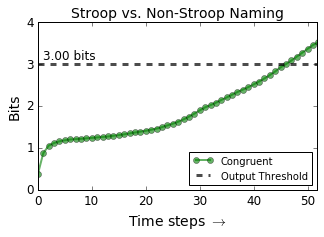

In [22]:
color="Green"
other="Red"

context = make_context(naming=True, eng=True)
params = make_routing_params(sem_input_strength=1.0, eng_input_strength=0.5, sem2eng_strength=0.05, eng2sem_strength=0.0, thresh=3.0)
routing_params, sem_act, eng_act, sem_hist, eng_hist, sem_bits, eng_bits, final_t = run_name_color_no_bg(lex, context, routing_params=params, sem_col = color, eng_col = other, sess=sess)

plot_info_progress(lex, context, params, [eng_bits], [eng_hist], final_t, colors=['g'])#, plot_title="%s/%s"%(color,other))

# params = naming_pop8.ix[0]
# routing_params, sem_act, spa_act, sem_hist, spa_hist2, sem_bits, spa_bits2, final_t2 = run_name_color_no_bg(lex, context, routing_params=params, sem_col = color, eng_col = None, sess=sess)
# params = naming_pop8.ix[0]
# routing_params, sem_act, spa_act, sem_hist, spa_hist3, sem_bits, spa_bits3, final_t3 = run_name_color_no_bg(lex, context, routing_params=params, sem_col = color, eng_col = other, sess=sess)
# plot_info_progress(lex, context, params, [spa_bits, spa_bits2, spa_bits3], [spa_hist, spa_hist2, spa_hist3], max(final_t, final_t2, final_t3), colors=['g','b','r'])#, plot_title="%s/%s"%(color,other))

xlabel(r"Time steps $\rightarrow$")

#savefig(rundir+"info_state_fig-1-30.pdf")
#savefig(rundir+"info_state_fig-1-30.png", ppi=600)

In [23]:
def plot_naming_act(model, context, routing_params, sem_act, eng_act, sem_hist, eng_hist, sem_bits, eng_bits, final_t, plot_times=None, plot_every=5, sess=sess):   
 
    if plot_times is not None:
        times = plot_times 
    else:
        times = [tt for tt in range(0, final_t, plot_every)]
    if times[-1] != final_t:
        times.append(final_t)
        
    rows = len(times)

    figsize(8,2.5*rows)

    for p,tt in enumerate(times):

        subplot(rows,4,p*4+1)
        if tt==plot_times[0]:
            title("Semantic map", fontsize=12)
        else:
            title("")
        imshow(sem_act[tt],cmap="Reds", vmin=0.0)
        xticks([]); yticks([])
        x,y = np.unravel_index(sem_act[tt].argmax(), sem_act[tt].shape)
        #text(5,5,"TEST", color='k')
        text(y,x, lex.get_color_name(lex.sem.labels[x,y]), color='silver', ha='center', va='center', fontsize=10)
        ylabel("Time=%d"%tt, fontsize=12)
        
        subplot(rows,4,p*4+2)
        bar(range(len(sem_hist[tt])),sem_hist[tt], color=model.input_labels)
        if tt==times[-1]:
            xticks(arange(0.5,16.5,1), model.input_labels, rotation=90, fontsize=8)
        else:
            xticks([])
        ylim(0,1.05); xlim(0,16); yticks([])        
        text(0.95,0.9,"%.2f bits"%sem_bits[tt], fontsize=12)

        subplot(rows,4,p*4+3)
        if tt==plot_times[0]:
            title("Phonetic map", fontsize=12)
        else:
            title("")
        imshow(eng_act[tt], cmap="Greens", vmin=0.0)
        xticks([]); yticks([])
        x,y = np.unravel_index(eng_act[tt].argmax(), eng_act[tt].shape)
        text(y,x, lex.get_color_name(lex.eng.labels[x,y]), color='silver', ha='center', va='center', fontsize=10)


        subplot(rows,4,p*4+4)
        bar(range(len(eng_hist[tt])),eng_hist[tt], color=model.input_labels)
        if tt==times[-1]:
            xticks(arange(0.5,16.5,1), model.input_labels, rotation=90, fontsize=8)
        else:
            xticks([])
        ylim(0,1.05); xlim(0,16); yticks([])        
        text(0.95,0.9,"%.2f / %.2f bits"%(eng_bits[tt], routing_params["thresh"]), fontsize=12)
        
        #axhline(routing_params["thresh"], '--k') not here

    #subplots_adjust(hspace=0.35)
    

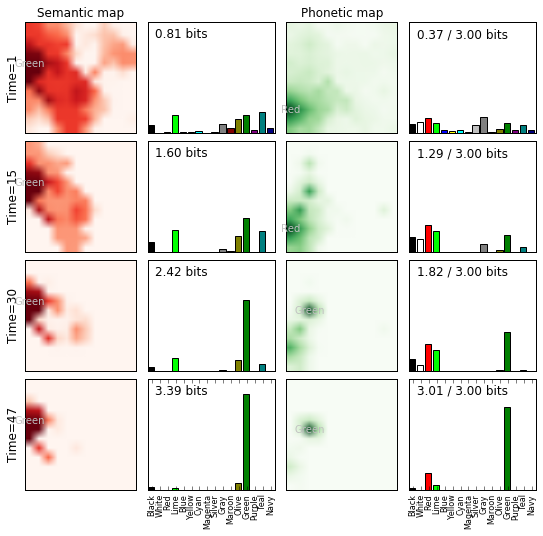

In [24]:
plot_naming_act(lex, context, routing_params, sem_act, eng_act, sem_hist, eng_hist, sem_bits, eng_bits, final_t, plot_times=[1,15,30])
subplots_adjust(wspace=0.03, hspace=0.07, right=1.0, left=0.1, top=0.9, bottom=0.25)

#savefig(rundir+"maps_blue_green_nn-1-30.pdf")